In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, skew
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


In [2]:
train_data= pd.read_csv('Train_data.csv')
test_data=pd.read_csv('Test_data.csv')
print(train_data.shape)
train_data.head()

(4571, 9)


,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4571 entries, 0 to 4570
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         4571 non-null   object 
 1   campaign     4571 non-null   object 
 2   adgroup      4571 non-null   object 
 3   ad           4571 non-null   object 
 4   impressions  4571 non-null   int64  
 5   clicks       4571 non-null   int64  
 6   cost         4571 non-null   float64
 7   conversions  4571 non-null   int64  
 8   revenue      4571 non-null   float64
dtypes: float64(2), int64(3), object(4)
memory usage: 321.5+ KB


In [4]:
train_data.describe()

,impressions,clicks,cost,conversions,revenue
count,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000
mean,92.635747,43.340844,2.800834,1.339094,231.865340
std,198.349737,100.164913,14.361618,5.223922,1091.742763
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,2.000000,0.040000,0.000000,0.000000
50%,16.000000,7.000000,0.210000,0.000000,0.000000
75%,84.000000,38.000000,1.350000,1.000000,92.600000
max,3239.000000,1771.000000,531.250000,94.000000,20515.410000


In [5]:
target = 'revenue'
print(train_data[target].describe())

count     4571.000000
mean       231.865340
std       1091.742763
min          0.000000
25%          0.000000
50%          0.000000
75%         92.600000
max      20515.410000
Name: revenue, dtype: float64


In [6]:
print("Skewness: %f" % train_data[target].skew()) 

Skewness: 11.661765


In [7]:
train_data['revenue'] = np.log1p(train_data[target])
print("Skewness: %f" % train_data[target].skew())

Skewness: 1.090641


In [8]:
y_train = train_data[target]
all_data = pd.concat([train_data, test_data], axis=0, sort=False)
all_data = all_data.drop([target], axis=1)


In [10]:
s = (all_data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['date', 'campaign', 'adgroup', 'ad']


In [11]:
object_nunique = list(map(lambda col: all_data[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

sorted(d.items(), key=lambda x: x[1])

[('campaign', 1), ('adgroup', 4), ('ad', 75), ('date', 227)]

In [12]:
low_cardinality_cols = [col for col in object_cols if all_data[col].nunique() < 10]

# columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))
print(high_cardinality_cols)

['date', 'ad']


In [13]:
for element in high_cardinality_cols:
    all_data.drop(element, axis=1, inplace=True)

In [15]:
Total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([Total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

,Total,Percent
conversions,0,0.0
cost,0,0.0
clicks,0,0.0
impressions,0,0.0
adgroup,0,0.0
campaign,0,0.0


In [16]:
all_data.drop((missing_data[missing_data['Percent'] > 0.1]).index, axis=1, inplace=True)
print(all_data.isnull().sum().max())

0


In [17]:
total = all_data.isnull().sum().sort_values(ascending=False)
total.head()

conversions    0
cost           0
clicks         0
impressions    0
adgroup        0
dtype: int64

In [18]:
total = all_data.isnull().sum().sort_values(ascending=False)
total.head()

conversions    0
cost           0
clicks         0
impressions    0
adgroup        0
dtype: int64

In [19]:
s = (all_data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['campaign', 'adgroup']


In [20]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_all = pd.DataFrame(OH_encoder.fit_transform(all_data[object_cols]))
OH_cols_all.index = all_data.index
num_all_data = all_data.drop(object_cols, axis=1)
OH_all_data = pd.concat([num_all_data, OH_cols_all], axis=1)
OH_all_data.head()

,impressions,clicks,cost,conversions,0,1,2,3,4
0,24,6,0.08,0,1.0,1.0,0.0,0.0,0.0
1,1,0,0.00,0,1.0,0.0,1.0,0.0,0.0
2,13,4,0.04,0,1.0,0.0,0.0,1.0,0.0
3,5,4,0.08,0,1.0,0.0,0.0,0.0,1.0
4,247,126,1.29,4,1.0,1.0,0.0,0.0,0.0


In [21]:
x_train = OH_all_data[:len(y_train)]
x_test = OH_all_data[len(y_train):]

x_test.shape , x_train.shape

((318, 9), (4571, 9))

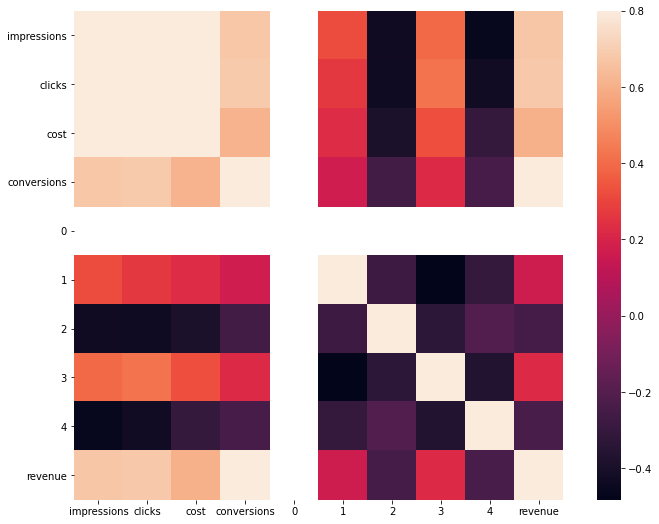

In [22]:
train_corr = x_train.join(y_train)
train_corr_matrix = train_corr.corr(method='spearman')

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train_corr_matrix, vmax=.8, square=True);

In [23]:
prefeatures = train_corr_matrix[(train_corr_matrix[target]>0.1) | (train_corr_matrix[target]<-0.1)].index.tolist()
prefeatures.remove(target)
print(prefeatures)

['impressions', 'clicks', 'cost', 'conversions', 1, 2, 3, 4]


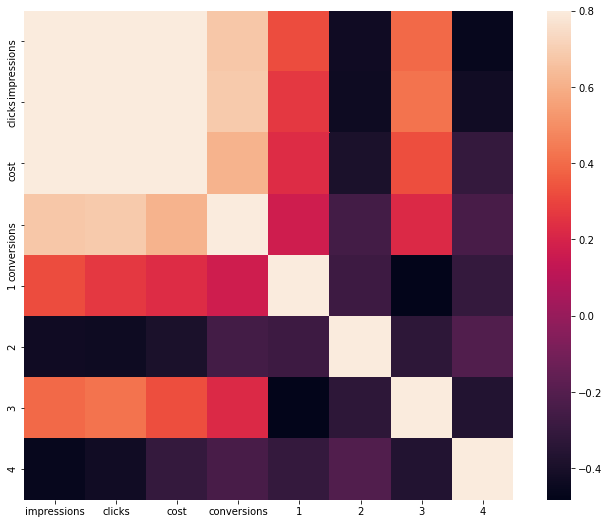

In [24]:
features_corr = train_corr[prefeatures]
features_corr_matrix = features_corr.corr(method='spearman')

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(features_corr_matrix, vmax=.8, square=True);

In [25]:
s = features_corr_matrix.unstack()
so = s.sort_values(kind='quicksort')
so = so.to_frame(name='correlation')
so.drop(so.loc[so['correlation']==1].index, inplace=True)
so.drop(so.loc[(so['correlation'] <= 0.8) & (so['correlation']>= -0.8)].index, inplace=True)
so.shape

(6, 1)

In [28]:
so.head(30)

,,correlation
cost,impressions,0.846177
impressions,cost,0.846177
clicks,cost,0.879657
cost,clicks,0.879657
impressions,clicks,0.971858
clicks,impressions,0.971858


In [30]:
#model and evaluation
y = y_train
features=['cost','impressions','clicks']
X = x_train[features]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

revenue_model = RandomForestRegressor(n_estimators = 400,
min_samples_split = 2,
 min_samples_leaf = 1,
 max_features = 'sqrt',
 max_depth = None,
bootstrap = False,
 random_state = 1)
revenue_model.fit(train_X, train_y)
revenue_model_pred =revenue_model.predict(val_X)

In [31]:
revenue_model_mae = mean_absolute_error(np.expm1(revenue_model_pred), np.expm1(val_y))

print("Validation MAE for Random Forest Model: {}".format(revenue_model_mae))

Validation MAE for Random Forest Model: 136.07542037561566


In [32]:
rf_model_on_full_data = RandomForestRegressor(n_estimators = 400,
min_samples_split = 2,
 min_samples_leaf = 1,
 max_features = 'sqrt',
 max_depth = None,
bootstrap = False,
 random_state = 1)
rf_model_on_full_data.fit(X, y)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400,
                      random_state=1)

In [33]:
# apply to test data
test_X = x_test[features]
test_preds = np.expm1(rf_model_on_full_data.predict(test_X))

In [34]:
output = pd.DataFrame({'revenue': test_preds})
output.to_csv('submission.csv', index=False)

In [3]:
# import data and checking
test_sub = pd.read_csv('Sample_Submission.csv')
sub = pd.read_csv('submission.csv')

test_sub.shape, sub.shape

((318, 1), (318, 1))

In [4]:
sub.head()

,revenue
0,10.610357
1,0.945917
2,0.000000
3,0.085928
4,0.000000
